In [1]:
import numpy as np

In [14]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0,x)

def der_sigmoid(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)


def der_relu(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ


class GenData:
    @staticmethod
    def _gen_linear(n=100):
        """Data generation (Linear)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        pos = np.array([(np.random.random(), np.random.random()) for i in range(n)])
        x, y = pos[:, 0], pos[:, 1]
        return pos, (x > y).astype(np.int64).reshape((-1, 1))

    @staticmethod
    def _gen_xor(n=100):
        """Data generation (XOR)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data_x = np.linspace(0, 1, n // 2)

        inputs = []
        labels = []

        for x in data_x:
            inputs.append([x, x])
            labels.append(0)

            if x == 1 - x:
                continue

            inputs.append([x, 1 - x])
            labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def _gen_chessboard(n=100):

        pos = np.array([(np.random.random(), np.random.random()) for i in range(n)])
        x, y = pos[:, 0], pos[:, 1]
        return pos, ((x < 0.25) ^ (x > 0.5) ^ (x > 0.75) ^ (y < 0.25) ^ (y > 0.5) ^ (y > 0.75)).astype(np.int64).reshape(
            (-1, 1)
        )

    @staticmethod
    def fetch_data(mode, n):
        """Data gather interface

        Args:
            mode (str): 'Linear' or 'XOR', indicate which generator is used.
            n (int):    the number of data points generated in total.
        """
        assert mode == "Linear" or mode == "XOR" or mode == "Chessboard"

        data_gen_func = {"Linear": GenData._gen_linear, "XOR": GenData._gen_xor, "Chessboard": GenData._gen_chessboard}[mode]

        return data_gen_func(n)


class SimpleNet:
    def __init__(self, num_step=6000, print_interval=100, learning_rate=1e-2):
        self.num_step = num_step
        self.print_interval = print_interval
        self.learning_rate = learning_rate

        self.nn_architecture = [
            {"input_dim": 2, "output_dim": 100, "activation": "relu"},
            {"input_dim": 100, "output_dim": 50, "activation": "relu"},
            {"input_dim": 50, "output_dim": 10, "activation": "relu"},
            {"input_dim": 10, "output_dim": 1, "activation": "sigmoid"},
        ]


    @staticmethod
    def plot_result(data, gt_y, pred_y):

        assert data.shape[0] == gt_y.shape[0] == pred_y.shape[0], f"{data.shape}, {gt_y.shape}, {pred_y.shape}"

        plt.figure(figsize=(11, 5))

        plt.subplot(121)
        plt.title("Ground Truth", fontsize=18)
        plt.scatter(data[:,0], data[:,1], c=gt_y[:,0], cmap=plt.cm.bwr)

        plt.subplot(122)
        plt.title("Prediction", fontsize=18)
        plt.scatter(data[:,0], data[:,1], c=pred_y[:,0], cmap=plt.cm.bwr)

        plt.show()

    def init_layers(self, nn_architecture, seed = 99):
        np.random.seed(seed)
        params_values = {}

        for layer_idx, layer in enumerate(nn_architecture,1):

            layer_input_size = layer["input_dim"]
            layer_output_size = layer["output_dim"]
            params_values['W' + str(layer_idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
            params_values['b' + str(layer_idx)] = np.random.randn(layer_output_size, 1) * 0.1

        return params_values

    def single_layer_forward(self, A_prev, W_curr, b_curr, activation="relu"):

        Z_curr = W_curr@A_prev + b_curr

        if activation == "relu":
            activation_func = relu
        elif activation == "sigmoid":
            activation_func = sigmoid


        return activation_func(Z_curr), Z_curr

    def forward(self, X, params_values, nn_architecture):
        memory = {}
        A_curr = X.T

        for idx, layer in enumerate(nn_architecture):
            layer_idx = idx + 1
            A_prev = A_curr

            activ_function_curr = layer["activation"]
            W_curr = params_values["W" + str(layer_idx)]
            b_curr = params_values["b" + str(layer_idx)]
            A_curr, Z_curr = self.single_layer_forward(A_prev, W_curr, b_curr, activ_function_curr)

            memory["A" + str(idx)] = A_prev
            memory["Z" + str(layer_idx)] = Z_curr

        return A_curr, memory

    def single_layer_backward(self, dA_curr, W_curr, Z_curr, A_prev, activation="relu"):

        if activation == "relu":
            backward_activation_func = der_relu
        elif activation == "sigmoid":
            backward_activation_func = der_sigmoid

        dZ_dC = backward_activation_func(dA_curr, Z_curr)
        dW_curr = np.dot(dZ_dC, A_prev.T)
        db_curr = np.sum(dZ_dC, axis=1, keepdims=True)
        dA_prev = np.dot(W_curr.T, dZ_dC)

        return dA_prev, dW_curr, db_curr

    def backward(self, output, label, memory, params_values, nn_architecture):
        grads = {}

        dA_prev = - (np.divide(label, output) - np.divide(1 - label, 1 - output))

        for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
            layer_idx_curr = layer_idx_prev + 1
            activ_function_curr = layer["activation"]

            dA_curr = dA_prev

            A_prev = memory["A" + str(layer_idx_prev)]
            Z_curr = memory["Z" + str(layer_idx_curr)]
            W_curr = params_values["W" + str(layer_idx_curr)]

            dA_prev, dW_curr, db_curr = self.single_layer_backward(
                dA_curr, W_curr, Z_curr, A_prev, activ_function_curr)

            grads["dW" + str(layer_idx_curr)] = dW_curr
            grads["db" + str(layer_idx_curr)] = db_curr

        return grads

    def update(self, params, grads, nn_architecture, learning_rate):
        for layer_idx, layer in enumerate(nn_architecture,1):
            params["W" + str(layer_idx)] -= learning_rate * grads["dW" + str(layer_idx)]
            params["b" + str(layer_idx)] -= learning_rate * grads["db" + str(layer_idx)]

        return params

    def train(self, inputs, labels):
        params_values = self.init_layers(self.nn_architecture)
        assert inputs.shape[0] == labels.shape[0]
        n = inputs.shape[0]

        for epochs in range(self.num_step):
            for idx in range(n):

                self.output, memory = self.forward(inputs[idx : idx + 1, :], params_values, self.nn_architecture)

                self.error = self.output - labels[idx : idx + 1, :]
                grads = self.backward(self.output, labels[idx : idx + 1, :], memory, params_values, self.nn_architecture)
                params_values = self.update(params_values, grads, self.nn_architecture,self.learning_rate)

            #if epochs % self.print_interval == 0:
            print(f"\rEpochs {epochs}: loss : {self.error}", end="")
            self.test(inputs, labels, params_values)

        print("Training finished")
        self.test(inputs, labels, params_values)
        return params_values

    def test(self, inputs, labels, params_values):
        n = inputs.shape[0]

        error = 0.0
        for idx in range(n):
            result, _ = self.forward(inputs[idx : idx + 1, :], params_values, self.nn_architecture)
            error += abs(result - labels[idx : idx + 1, :])

        error /= n
        if (1 - error) * 100 >= 80:
            self.learning_rate = 0.002
        """ Print or plot your results in your preferred forms"""
        print("accuracy: %.2f" % ((1 - error) * 100) + "%", end='')

In [36]:
# plt.figure(figsize=(17, 5))
# for i, name in enumerate(['Linear', 'XOR', 'Chessboard']):
#     data, label = GenData.fetch_data(name, 1000)
#     plt.subplot(1,3,i+1)
#     plt.scatter(data[:, 0], data[:, 1], c=label[:, 0], cmap=plt.cm.bwr)
#     plt.title(name)

Epochs 14: loss : [[0.00741627]]accuracy: 96.64%Training finished
accuracy: 96.64%

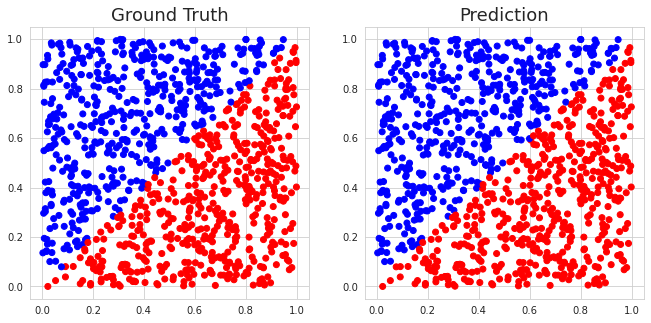

In [18]:
data, label = GenData.fetch_data('Linear', 1000)
model = SimpleNet(15)
params = model.train(data, label)
pred_result, _ = model.forward(data, params, model.nn_architecture)
pred_result = np.round(pred_result)
SimpleNet.plot_result(data, label, pred_result.T)

Epochs 199: loss : [[0.02305903]]accuracy: 96.19%Training finished
accuracy: 96.19%

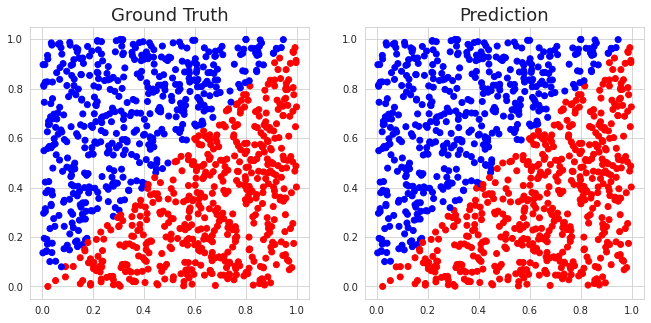

In [13]:
data, label = GenData.fetch_data('Linear', 1000)
model = SimpleNet(200)
params = model.train(data, label)
pred_result, _ = model.forward(data, params, model.nn_architecture)
pred_result = np.round(pred_result)
SimpleNet.plot_result(data, label, pred_result.T)

Epochs 149: loss : [[-2.08721929e-14]]accuracy: 94.38%Training finished
accuracy: 94.38%

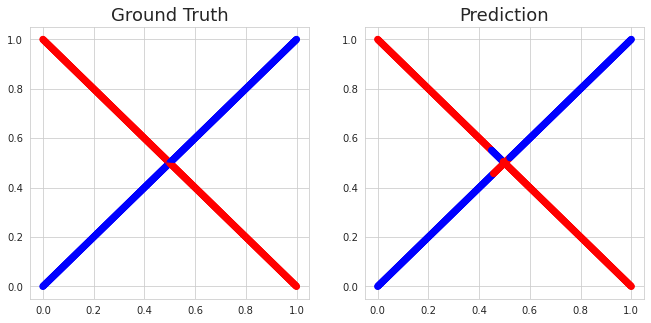

In [10]:
data, label = GenData.fetch_data('XOR', 1000)
model = SimpleNet(150)
params = model.train(data, label)
pred_result, _ = model.forward(data, params, model.nn_architecture)
pred_result = np.round(pred_result)
SimpleNet.plot_result(data, label, pred_result.T)

Epochs 699: loss : [[-0.00073978]]accuracy: 93.09%Training finished
accuracy: 93.09%

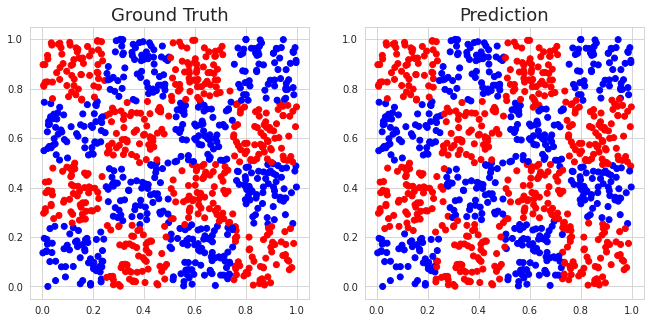

In [5]:
data, label = GenData.fetch_data('Chessboard', 1000)
model = SimpleNet(700)
params = model.train(data, label)
pred_result, _ = model.forward(data, params, model.nn_architecture)
pred_result = np.round(pred_result)
SimpleNet.plot_result(data, label, pred_result.T)

Epochs 699: loss : [[-0.00073978]]accuracy: 93.09%Training finished
accuracy: 93.09%

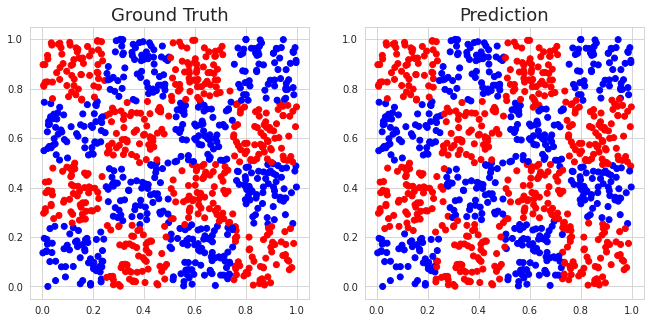

In [7]:
data, label = GenData.fetch_data('Chessboard', 1000)
model = SimpleNet(700)
params = model.train(data, label)
pred_result, _ = model.forward(data, params, model.nn_architecture)
pred_result = np.round(pred_result)
SimpleNet.plot_result(data, label, pred_result.T)